# Non-linear Tracking MPC

In this notebook, we will design an nonlinear tracking model-predictive controller (MPC) for a heat exchanger. We will asume that both system and disturbance states are perfectly known and that the prediction model agrees perfectly with the true system dynamics. The code uses a nonlinear mpc package developed in CasADi. 

## Define the Model Parameters

We begin by defining the model parameters for the heat exchanger.


In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from openmpc.models import NonlinearSystem
from openmpc.mpc import SetPointTrackingNMPC , MPCProblem

# Define the model parameters
C_hot = 5000  # Heat capacity of hot fluid (J/K)
C_cold = 5000  # Heat capacity of cold fluid (J/K)
c_p_hot = 2000  # Specific heat capacity of hot fluid (J/kg·K)
c_p_cold = 4184  # Specific heat capacity of cold fluid (J/kg·K)
U = 500  # Overall heat transfer coefficient (W/m²*K)
A = 50  # Heat transfer area (m²)

## Define the System States and Control Inputs

We will now define the system states and control inputs.


In [2]:
# Define the system states and control inputs
T_hot = ca.MX.sym('T_hot')
T_hot_in = ca.MX.sym('T_hot_in')
T_cold = ca.MX.sym('T_cold')
T_cold_in = ca.MX.sym('T_cold_in')
m_dot_hot = ca.MX.sym('m_dot_hot')
m_dot_cold = ca.MX.sym('m_dot_cold')


## Define the Prediction Model

Next, we define the prediction model for the heat exchanger.


In [ ]:
# Define prediction model
samplingTime = 0.1

dT_hot  = (1 / C_hot) * (m_dot_hot * c_p_hot * (T_hot_in - T_hot) - U * A * (T_hot - T_cold))
dT_cold = (1 / C_cold) * (m_dot_cold * c_p_cold * (T_cold_in - T_cold) + U * A * (T_hot - T_cold))

rhs    = ca.vertcat(dT_hot, dT_cold)
states = ca.vertcat(T_hot, T_cold)
inputs = ca.vertcat(m_dot_hot, m_dot_cold)
disturbances = ca.vertcat(T_hot_in, T_cold_in)

# Create the NonlinearSystem object
heat_exchanger_system = NonlinearSystem.c2d(updfcn=rhs, states=states, inputs=inputs, disturbances=disturbances, h=samplingTime)

## Define Disturbance Profiles and Desired Output

We define the disturbance profiles and the desired output temperatures for the heat exchanger.


In [4]:
# Define disturbance profiles
T_hot_in = 150  # Nominal inlet temperature of hot fluid (°C)
T_cold_in = 25  # Nominal inlet temperature of cold fluid (°C)

# Define desired outlet temperatures
T_hot_ref = 110  # Desired outlet temperature of hot fluid (°C)
T_cold_ref = 50  # Desired outlet temperature of cold fluid (°C)


## Define the MPC Controller

Now, we define the MPC controller using the prediction model and other parameters.


In [5]:
Q=np.diag([1, 1])
R=np.diag([0.1, 0.05])

# Compute the LQR controller and the corresponding Riccati solution
dnom = np.array([T_hot_in, T_cold_in])
yref = np.array([T_hot_ref, T_cold_ref])
(xref, uref) = heat_exchanger_system.get_target_point(yref, dnom)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [6]:
L, P = heat_exchanger_system.compute_lqr_controller(Q, R, xref, uref, dnom)

In [7]:
mpc_problem = MPCProblem(system = heat_exchanger_system,
                          horizon = 10, 
                          Q     = Q, 
                          R     = R, 
                          QT    = P)

mpc_problem.add_input_bound_constraint(limits = (1,20), input_index=0,is_hard=False,penalty_weight=1e6)
mpc_problem.add_input_bound_constraint(limits = (1,30), input_index=1,is_hard=False,penalty_weight=1e6)
mpc_problem.add_dual_mode(horizon=5, controller=L)
mpc_problem.add_reference_controller(L)


# Initialize the MPC controller
mpc = SetPointTrackingNMPC(mpc_problem)


## Set Up Simulation

We will now set up the simulation environment and define the simulation model.


In [8]:

Tsim = 20  # Final time (hours)
time = np.arange(0, Tsim, samplingTime)

# Define the initial conditions
T_hot_0 = 120  # Initial temperature of hot fluid (°C)
T_cold_0 = 40  # Initial temperature of cold fluid (°C)

# Initial state
x0   = np.array([T_hot_0, T_cold_0])
yref = np.array([T_hot_ref, T_cold_ref])
d    = np.array([T_hot_in, T_cold_in])

# Initialize state and control trajectories for simulation
x_sim = [x0]
u_sim = []

n = len(x0)

for k in range(len(time)):
    x_current = x_sim[-1]
    
    if time[k] > 5:
        d[1] = T_cold_in + 5

    if time[k] > 10:
        yref[0] = T_hot_ref - 10
    
    
    u_current = mpc.get_control_action(x_current, yref, d)
    

    # Integrate the state using the simulation model
    x_next = heat_exchanger_system.discrete_dynamics(x_current, u_current, d)
    
    # Store the control action and the next state
    u_sim.append(u_current)
    x_sim.append(x_next)

    # Print status every hour of simulation time
    if (k + 1) % int(1 / samplingTime) == 0:
        sim_time = (k + 1) * samplingTime
        print(f"Simulation time: {sim_time:.2f} hours. Current system state: {x_next}")


x_sim = np.array(x_sim)
u_sim = np.array(u_sim)



Simulation time: 1.00 hours. Current system state: [109.99999731  50.00000098]
Simulation time: 2.00 hours. Current system state: [110.  50.]
Simulation time: 3.00 hours. Current system state: [110.  50.]
Simulation time: 4.00 hours. Current system state: [110.  50.]
Simulation time: 5.00 hours. Current system state: [110.  50.]
Simulation time: 6.00 hours. Current system state: [110.  50.]
Simulation time: 7.00 hours. Current system state: [110.  50.]
Simulation time: 8.00 hours. Current system state: [110.  50.]
Simulation time: 9.00 hours. Current system state: [110.  50.]
Simulation time: 10.00 hours. Current system state: [110.  50.]
Simulation time: 11.00 hours. Current system state: [99.9999999  50.00000003]
Simulation time: 12.00 hours. Current system state: [100.  50.]
Simulation time: 13.00 hours. Current system state: [100.  50.]
Simulation time: 14.00 hours. Current system state: [100.  50.]
Simulation time: 15.00 hours. Current system state: [100.  50.]
Simulation time: 16

## Plot the Results

Finally, we plot the results of the simulation, showing the temperature trajectories and the control trajectories.


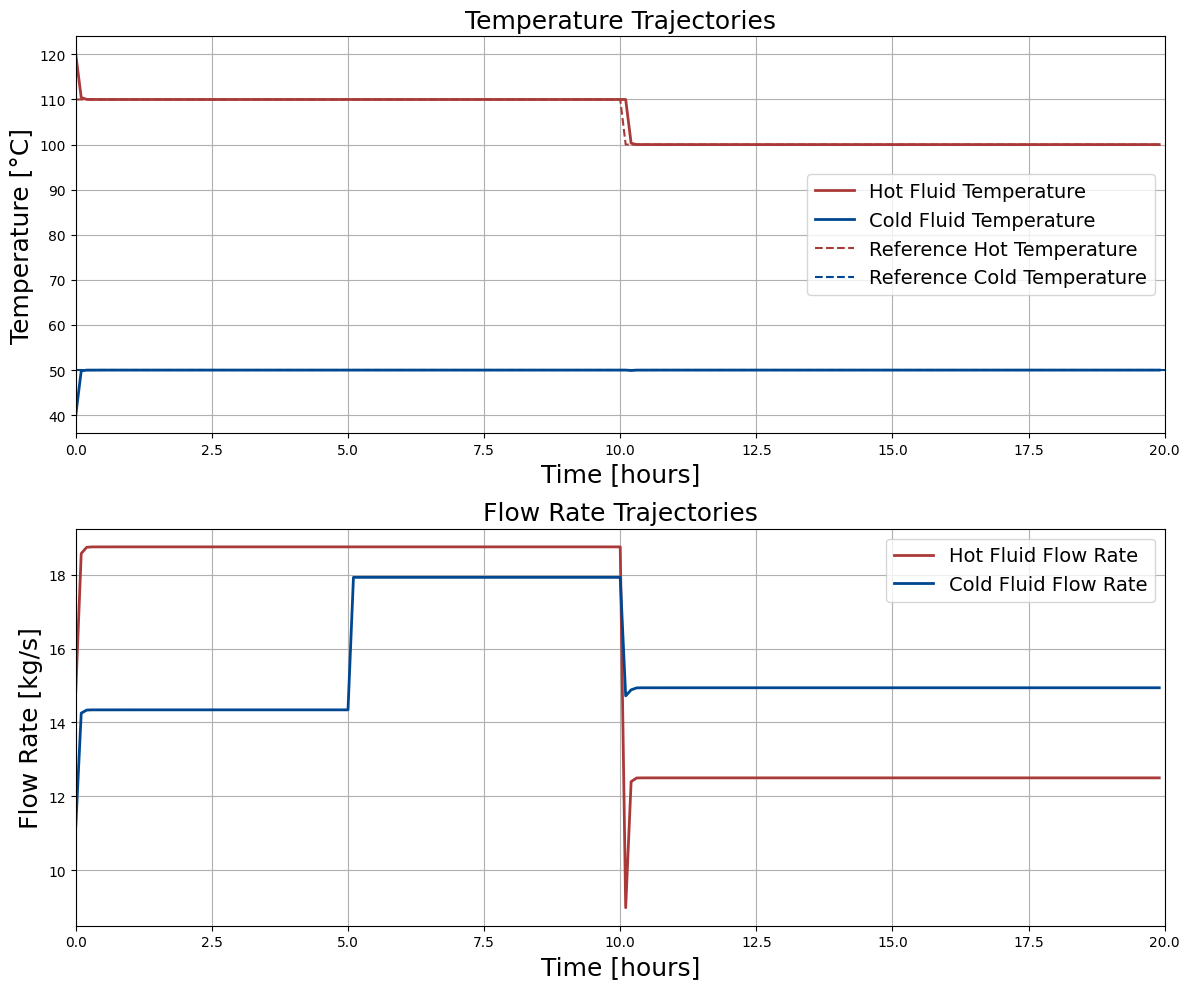

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Time grid for plotting
t_sim = time

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the state trajectories on the first subplot
ax1.plot(t_sim, x_sim[:-1, 0], label='Hot Fluid Temperature', color='#AA3939', linewidth=2)
ax1.plot(t_sim, x_sim[:-1, 1], label='Cold Fluid Temperature', color='#004791', linewidth=2)

# Update reference values to reflect the change at T = 10
T_hot_ref_updated = np.array([T_hot_ref if t <= 10 else T_hot_ref-10 for t in t_sim])
ax1.plot(t_sim, T_hot_ref_updated, color='#AA3939', linestyle='--', label='Reference Hot Temperature')
ax1.axhline(T_cold_ref, color='#004791', linestyle='--', label='Reference Cold Temperature')

# Set x-limits
ax1.set_xlim([0, Tsim])

# Set labels, title, and legend
ax1.set_xlabel('Time [hours]', fontsize=18)
ax1.set_ylabel('Temperature [°C]', fontsize=18)
ax1.legend(fontsize=14)
ax1.set_title('Temperature Trajectories', fontsize=18)
ax1.grid(True)

# Plot the control trajectories on the second subplot
ax2.plot(t_sim, u_sim[:, 0], label='Hot Fluid Flow Rate', color='#AA3939', linewidth=2)
ax2.plot(t_sim, u_sim[:, 1], label='Cold Fluid Flow Rate', color='#004791', linewidth=2)

# Set x-limits
ax2.set_xlim([0, Tsim])

# Set labels, title, and legend
ax2.set_xlabel('Time [hours]', fontsize=18)
ax2.set_ylabel('Flow Rate [kg/s]', fontsize=18)
ax2.legend(fontsize=14)
ax2.set_title('Flow Rate Trajectories', fontsize=18)
ax2.grid(True)

# Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.show()

